In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

#libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#libraries for evaluation
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split


#libraries for models


from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')


In [2]:
#Loading Dataframe

#df=pd.read_csv("vehiclesFinal2.csv")
df=pd.read_csv("vehiclesFinal.csv")
#df=df.drop('Unnamed: 0',axis=1)
df=df.drop('id',axis=1)

df2=df.copy()
df.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,mohave county,2012.0,jeep,patriot,like new,4 cylinders,gas,247071.0,clean,automatic,4wd,full-size,offroad,silver,34.4554,-114.2690,3495
1,oregon coast,2014.0,bmw,328i m-sport,good,5 cylinders,gas,76237.0,clean,automatic,rwd,full-size,sedan,grey,46.1837,-123.8240,13750
2,greenville / upstate,2001.0,dodge,caravan,excellent,6 cylinders,gas,199000.0,clean,automatic,4wd,full-size,offroad,grey,34.9352,-81.9654,2300
3,mohave county,2004.0,chevrolet,colorado ls,excellent,5 cylinders,gas,54000.0,clean,automatic,rwd,mid-size,pickup,red,34.4783,-114.2710,9000
4,maine,2005.0,ford,mustang convertible,excellent,6 cylinders,gas,62800.0,clean,automatic,rwd,mid-size,convertible,silver,44.2070,-69.7858,8500


In [3]:
#defining numerical and categorical values

num_col=['year','odometer','long','lat']
cat_cols=['region','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']

In [4]:
le=preprocessing.LabelEncoder()
df[cat_cols]=df[cat_cols].apply(le.fit_transform)

In [5]:
#scaling numerical data

norm = StandardScaler()
df['price'] = np.log(df['price'])
df['odometer'] = norm.fit_transform(np.array(df['odometer']).reshape(-1,1))
df['year'] = norm.fit_transform(np.array(df['year']).reshape(-1,1))
df['model'] = norm.fit_transform(np.array(df['model']).reshape(-1,1))

#scaling target variable
q1,q3=(df['price'].quantile([0.25,0.75]))
o1=q1-1.5*(q3-q1)
o2=q3+1.5*(q3-q1)
df=df[(df.price>=o1) & (df.price<=o2)]

df['region'] = norm.fit_transform(np.array(df['region']).reshape(-1,1))
df['lat'] = norm.fit_transform(np.array(df['lat']).reshape(-1,1))
df['long'] = norm.fit_transform(np.array(df['long']).reshape(-1,1))

In [6]:
df.head(2)

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,0.256165,0.157474,19,0.617681,3,3,2,2.611323,0,0,0,1,6,9,-0.661679,-1.077181,8.159089
1,0.582340,0.537358,4,-1.808705,2,4,2,-0.403124,0,0,2,1,9,5,1.266062,-1.607946,9.528794


In [7]:
#function to split dataset int training and test
def trainingData(df,n):
    X = df.iloc[:,n]
    y = df.iloc[:,-1:].values.T
    y=y[0]
    X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.9,test_size=0.1,random_state=0)
    return (X_train,X_test,y_train,y_test)

X_train,X_test,y_train,y_test=trainingData(df,list(range(len(list(df.columns))-1)))

In [8]:
#some of models will predict neg values so this function will remove that values
def remove_neg(y_test,y_pred):
    ind=[index for index in range(len(y_pred)) if(y_pred[index]>0)]
    y_pred=y_pred[ind]
    y_test=y_test[ind]
    y_pred[y_pred<0]
    return (y_test,y_pred)

#function for evaluation of model
def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)

#dataframe that store the performance of each model
accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])   

In [9]:
#BAGGING REGRESSOR
#model implementation
baggReg=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20),n_estimators=50, random_state=1,
                         max_samples=1.0, max_features=1.0, bootstrap=False, 
                         bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=-1, verbose=0)
baggReg.fit(X_train,y_train)
y_pred=baggReg.predict(X_test)

In [10]:
#model evaluation
r6_br=result(y_test,y_pred)
print("MSLE : {}".format(r6_br[0]))
print("Root MSLE : {}".format(r6_br[1]))
print("R2 Score : {} or {}%".format(r6_br[2],r6_br[3]))

MSLE : 0.0014319265033006466
Root MSLE : 0.03784080473907296
R2 Score : 0.7680896456627011 or 76.809%


In [11]:
accu['Bagging Regressor']=r6_br
accu.to_csv('errors.csv')

In [12]:
#RANDOM FOREST REGRESSOR
RFR = RandomForestRegressor(n_estimators=180,random_state=0, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
RFR.fit(X_train,y_train)
y_pred = RFR.predict(X_test)

In [13]:
r5_rf=result(y_test,y_pred)
print("MSLE : {}".format(r5_rf[0]))
print("Root MSLE : {}".format(r5_rf[1]))
print("R2 Score : {} or {}%".format(r5_rf[2],r5_rf[3]))
accu['RandomForest Regressor']=r5_rf

MSLE : 0.0007792733694474099
Root MSLE : 0.0279154682827892
R2 Score : 0.8758102787268343 or 87.581%


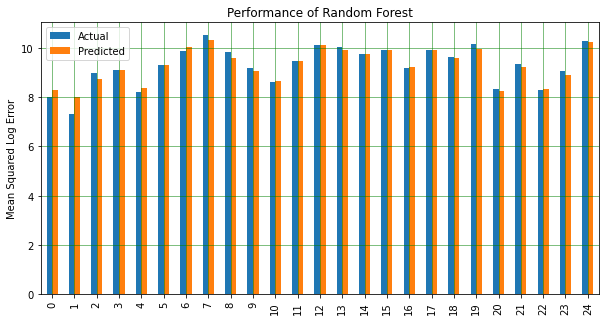

In [14]:
df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_check = df_check.head(25)
#round(df_check,2)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of Random Forest')
plt.ylabel('Mean Squared Log Error')
plt.savefig('Random-Forest-Performance.jpg')
plt.show()

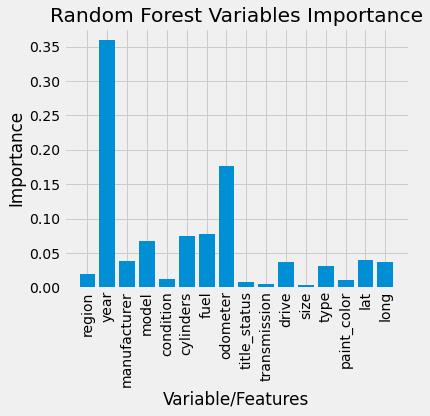

In [15]:
importances=RFR.feature_importances_
features=X_train.columns

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'))
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable/Features'); 
plt.title('Random Forest Variables Importance')
plt.tight_layout()
plt.savefig('Random-Forest-Variables-Importances.jpg',dpi=600)
plt.show();

In [16]:
#ADABOOST REGRESSOR
#model implementation
ABR = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=24),
    n_estimators=200,learning_rate=0.6
)

ABR.fit(X_train, y_train)
y_pred = ABR.predict(X_test)

In [17]:
#model evaluation
r7_ab=result(y_test,y_pred)
print("MSLE : {}".format(r7_ab[0]))
print("Root MSLE : {}".format(r7_ab[1]))
print("R2 Score : {} or {}%".format(r7_ab[2],r7_ab[3]))

MSLE : 0.0008422564177981482
Root MSLE : 0.029021654291203805
R2 Score : 0.8645151736376917 or 86.4515%


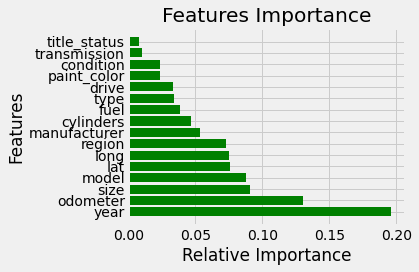

In [18]:
importances=ABR.feature_importances_
features=X_train.columns

indices = np.argsort(importances)
indices = [x for x in reversed(indices)]
plt.figure(1)
plt.title('Features Importance')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('Adaboost-Features-Importance2.jpg',dpi=60)
plt.show();

In [19]:
accu['AdaBoost Regressor']=r7_ab
accu.to_csv('errors.csv')

In [20]:
#K-NEAREST NEIGHBOR REGRESSOR
#estimating MSLE for k=1-9
R_MSLE=[]
for i in range(1,10):
    KNN=KNeighborsRegressor(n_neighbors=i)
    KNN.fit(X_train,y_train)
    y_pred=KNN.predict(X_test)
    error=np.sqrt(mean_squared_log_error(y_test, y_pred))
    R_MSLE.append(error)
    print("K =",i," , Root MSLE =",error)

K = 1  , Root MSLE = 0.043028479069752684
K = 2  , Root MSLE = 0.039043804337329305
K = 3  , Root MSLE = 0.03818394137951653
K = 4  , Root MSLE = 0.03797756432695356
K = 5  , Root MSLE = 0.03794905294871886
K = 6  , Root MSLE = 0.038011454947644976
K = 7  , Root MSLE = 0.038127287796045815
K = 8  , Root MSLE = 0.0382780007929938
K = 9  , Root MSLE = 0.038476219089292885


In [22]:
#model implementation
KNN=KNeighborsRegressor(n_neighbors=5) 
KNN.fit(X_train,y_train)
y_pred=KNN.predict(X_test)

In [23]:
#model evaluation
r4_knn=result(y_test,y_pred)
print("MSLE : {}".format(r4_knn[0]))
print("Root MSLE : {}".format(r4_knn[1]))
print("R2 Score : {} or {}%".format(r4_knn[2],r4_knn[3]))
accu['KNN']=r4_knn

MSLE : 0.0014401306197046673
Root MSLE : 0.03794905294871886
R2 Score : 0.7646628855468892 or 76.4663%


In [24]:
accu.to_csv('errors.csv')

In [25]:
#XGBOOST MODEL
#model implementation and fitting data
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
                max_depth = 24, alpha = 5, n_estimators = 200)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

In [26]:
#model evaluation
y_test_1,y_pred_1=remove_neg(y_test,y_pred)
r8_xg=result(y_test_1,y_pred_1)
print("MSLE : {}".format(r8_xg[0]))
print("Root MSLE : {}".format(r8_xg[1]))
print("R2 Score : {} or {}%".format(r8_xg[2],r8_xg[3]))

MSLE : 0.0006632488812319015
Root MSLE : 0.02575361879876111
R2 Score : 0.8945630662484907 or 89.4563%


In [28]:
accu['XGBoost Regressor']=r8_xg
accu.to_csv('errors.csv')

In [29]:
accu=pd.read_csv('./errors.csv',index_col=0)
accu

,Bagging Regressor,RandomForest Regressor,AdaBoost Regressor,KNN,XGBoost Regressor
MSLE,0.001432,0.000779,0.000842,0.001440,0.000663
Root MSLE,0.037841,0.027915,0.029022,0.037949,0.025754
R2 Score,0.768090,0.875810,0.864515,0.764663,0.894563
Accuracy(%),76.809000,87.581000,86.451500,76.466300,89.456300


In [30]:
model_accuracy=accu.loc['Accuracy(%)']

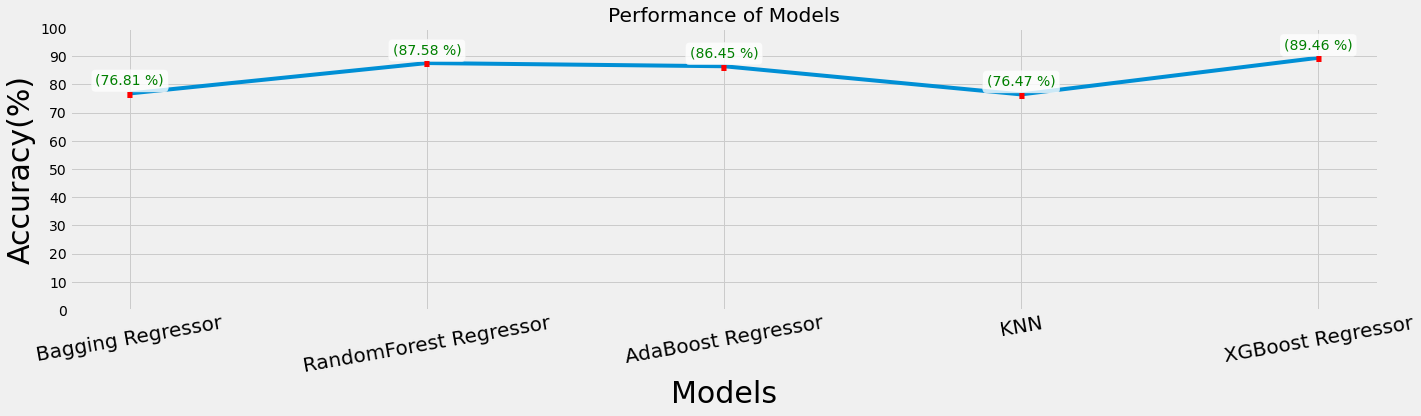

In [31]:
x=list(range(len(model_accuracy)))
y=list(range(0,101,10))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_accuracy)
plt.yticks(y)
plt.xticks(fontsize=20)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("Accuracy(%)",fontsize=30)
plt.title("Performance of Models")
for a,b in zip(x,y):
    b=model_accuracy[a]
    val="("+str(round(model_accuracy[a],2))+" %)"
    plt.text(a, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.savefig('Overall-Performance.jpg',dpi=600)
plt.show();